In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import japanize_matplotlib
from IPython.core.display import display

/var/folders/pt/19z35k5s1x76pkdz1df1mnqm0000gn/T/ipykernel_26303/2972655337.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [35]:
# train = pd.read_csv("csv/train.csv")
train = pd.read_csv("csv/processed_train.csv")
# test = pd.read_csv("csv/test.csv")
test = pd.read_csv("csv/processed_test.csv")
gender_submission = pd.read_csv("csv/gender_submission.csv")

In [36]:
sample_submission = pd.DataFrame(test["PassengerId"], columns=["PassengerId"])
train = pd.get_dummies(train, columns=["Sex", "Embarked"])
test = pd.get_dummies(test, columns=["Sex", "Embarked"])
train.drop(["PassengerId", "Name", "Cabin", "Ticket", "Title", "CategoricalAge", "CategoricalFare"], axis=1, inplace=True)
test.drop(["PassengerId", "Name", "Cabin", "Ticket", "Title"], axis=1, inplace=True)

display(train.head())
display(test.head())

,Survived,Pclass,Age,SibSp,Parch,Fare,SibSp_0_1_2over,Parch_0_1_2_3over,FamilySize,IsAlone,Title_num,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,2,1,3,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,2,1,4,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,0,1,0,2,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,2,1,4,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,0,1,0,3,0,1,0,0,1


,Pclass,Age,SibSp,Parch,Fare,SibSp_0_1_2over,Parch_0_1_2_3over,FamilySize,IsAlone,Title_num,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0,0,1,0,3,0,1,0,1,0
1,3,47.0,1,0,7.0000,1,0,2,1,4,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,0,1,0,3,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,0,1,0,3,0,1,0,0,1
4,3,22.0,1,1,12.2875,1,1,3,1,4,1,0,0,0,1


In [37]:
X_train = train.drop(["Survived"], axis=1)
y_train = train["Survived"]

In [38]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(valid_x, valid_y)

lgbm_params = {"objective":"binary"}

evals_result = {}
gbm = lgb.train(
    params=lgbm_params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=10
)

/Users/miyata/myKaggle-notebook/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/miyata/myKaggle-notebook/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/miyata/myKaggle-notebook/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbac

[LightGBM] [Info] Number of positive: 231, number of negative: 365
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 596, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387584 -> initscore=-0.457480
[LightGBM] [Info] Start training from score -0.457480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [39]:
oof = (gbm.predict(valid_x) > 0.5).astype(int)
print("score", round(accuracy_score(valid_y, oof)*100, 2))

score 83.05


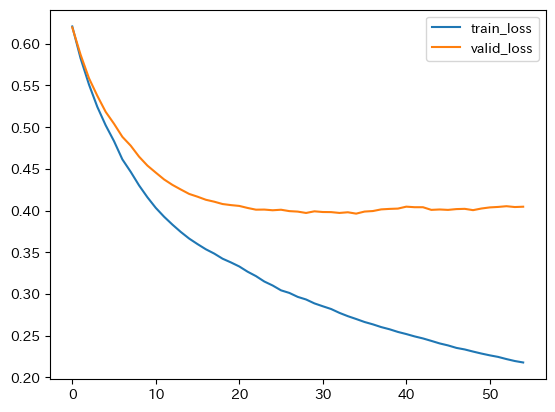

In [40]:
plt.plot(evals_result["training"]["binary_logloss"], label="train_loss")
plt.plot(evals_result["valid_1"]["binary_logloss"], label="valid_loss")
plt.legend()

In [ ]:
test_pred = (gbm.predict(test) > 0.5).astype(int)
sample_submission["Survived"] = test_pred
sample_submission.to_csv("train_test_split_vol2.csv", index=False)